## Calibrating a Classifier for a ImBalanced Dataset

In [61]:
# import libraries

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
# for preparation
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import(
    roc_auc_score,
    brier_score_loss,
    roc_curve,
)

# to get the calibrated points
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [64]:
# import data
path = '..\ImbalanceData_Analysis\kdd2004.csv'
df = pd.read_csv(path).sample(100000)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
82575,52.80,25.76,-1.82,-72.5,83.5,3393.0,-1.75,0.53,-11.0,-71.5,...,2857.7,1.50,1.73,-8.0,-54.0,1188.8,-0.91,0.31,-0.35,-1
32283,51.68,25.40,0.49,15.5,67.0,4963.7,-1.31,-0.94,-11.0,-92.0,...,5633.6,-1.18,0.96,-8.0,-155.0,1070.7,-1.31,0.31,0.54,-1
51025,78.15,25.98,-0.76,23.5,-9.5,1676.5,-2.82,-0.04,1.0,-77.0,...,1446.9,-2.61,-0.35,0.0,-45.0,649.3,-1.36,0.17,-0.50,-1
29358,30.09,23.81,-1.29,-7.5,38.5,997.4,-0.06,-1.12,-9.5,-40.5,...,384.3,-0.26,1.44,-4.0,-40.0,-90.7,1.87,0.67,0.49,-1
79835,68.57,24.32,-1.08,-25.0,19.5,1920.0,0.85,1.62,2.0,-100.5,...,2461.1,-0.79,3.70,17.0,-92.0,583.5,0.99,0.43,0.37,-1


In [65]:
# set X and y

X = df.drop('target', axis = 1)
y = df['target']

X.shape, y.shape


((100000, 74), (100000,))

In [66]:
y.value_counts()

-1    99107
 1      893
Name: target, dtype: int64

In [67]:
# split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((70000, 74), (30000, 74))

In [68]:
y_train.value_counts()

-1    69366
 1      634
Name: target, dtype: int64

In [69]:
y_train.value_counts()/len(y_train)

-1    0.990943
 1    0.009057
Name: target, dtype: float64

## Random Forest

In [71]:
# lets initialize a GaussianNB model object

rf = RandomForestClassifier(n_estimators=100,n_jobs=2,max_depth=5,class_weight='balanced')

rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=2)

In [72]:
# get the ROC scores

preds_train = rf.predict_proba(X_train)[:,1]
print('ROC score for train data : {}'.format(roc_auc_score(y_train,preds_train)))

preds_test = rf.predict_proba(X_test)[:,1]
print('ROC score for test data : {}'.format(roc_auc_score(y_test,preds_test)))

ROC score for train data : 0.9969556399552467
ROC score for test data : 0.9818942663164445


- We can see that the model performs quite well with both the training and test datasets as given by the roc_auc_score

## Brier Score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [73]:
# get the Brier scores for all models

bs_train = brier_score_loss(y_train,preds_train)
print('Brier score for train data : {}'.format(bs_train))

bs_test = brier_score_loss(y_test,preds_test)
print('Brier score for test data : {}'.format(bs_test))

Brier score for train data : 0.01770329692291271
Brier score for test data : 0.017903684052750977


The brier score also seems to be doing fair. Lets check by plotting the calibration curve

In [87]:
# lets write a function to plot the calibration curve

def plot_calibration_curve(y_test,preds_test,bins):
    
    plt.figure(figsize=(10,14))
    plt.subplot(2,1,1)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, preds_test, n_bins=bins,strategy='uniform')
    plt.plot(mean_predicted_value, fraction_of_positives,label='Random Forest')


    # draw the perfect calibrated line
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='--',c='red',label='Perfect Calibration')
    plt.legend(loc='best');
    plt.title('Calibration Curve')
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')

    # lets plot the distribution of the predicted probabilities as well
    plt.subplot(2,1,2)
    plt.hist(preds_test,range=(0,1),bins=bins,density=True,alpha = 0.5)
    plt.title('Density')
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')

    plt.show()

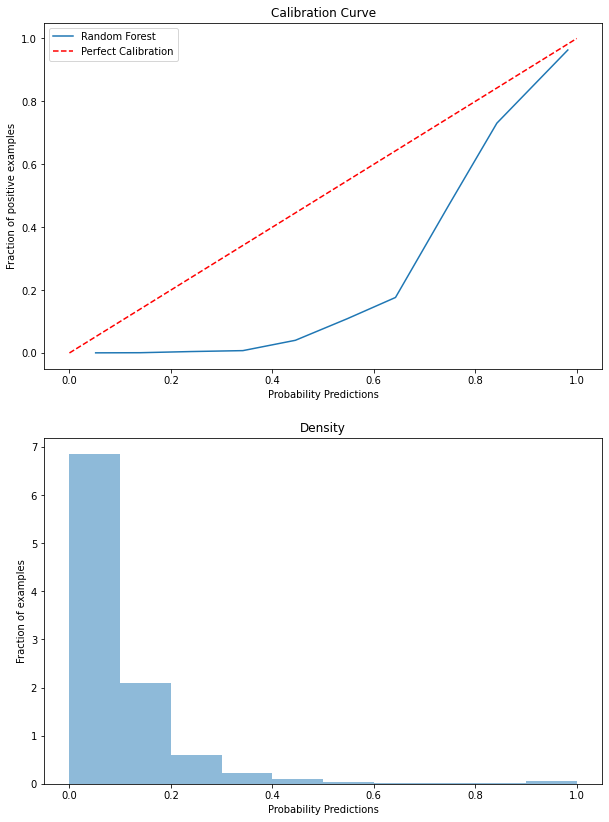

In [88]:
plot_calibration_curve(y_test,preds_test,bins=10)

The probability of the Gaussian NB model is uncalibrated. Prediction Distribution seems to be spreaded though

## Probability Re-calibration
- Now we'll try to calibrate our RF model predictions

In [76]:
# create a calibrated classifier cv 

# for isotonic method
clf_iso = CalibratedClassifierCV(base_estimator=rf, n_jobs=2, cv=5, method='isotonic')

# fitting the clf to our test data
# its best to keep some hold sample data, but for less data, we can do this method of cv
clf_iso.fit(X_test,y_test) 
# get the predictions
preds_iso = clf_iso.predict_proba(X_test)[:,1]


# for sigmoid method - or platt method
clf_sigmoid = CalibratedClassifierCV(base_estimator=rf, n_jobs=2, cv=5, method='sigmoid')
clf_sigmoid.fit(X_test,y_test) 
# get the predictions
preds_sigmoid = clf_sigmoid.predict_proba(X_test)[:,1]

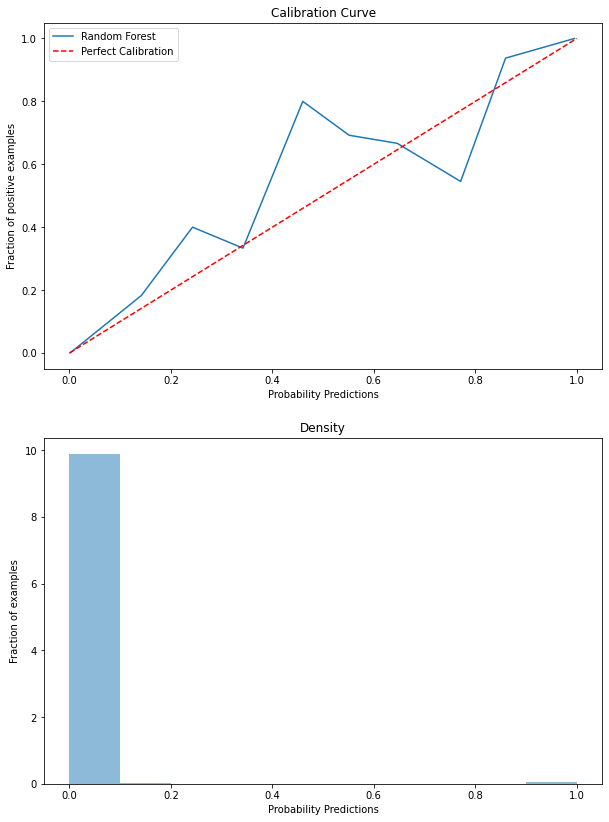

In [89]:
plot_calibration_curve(y_test,preds_iso,bins=10)

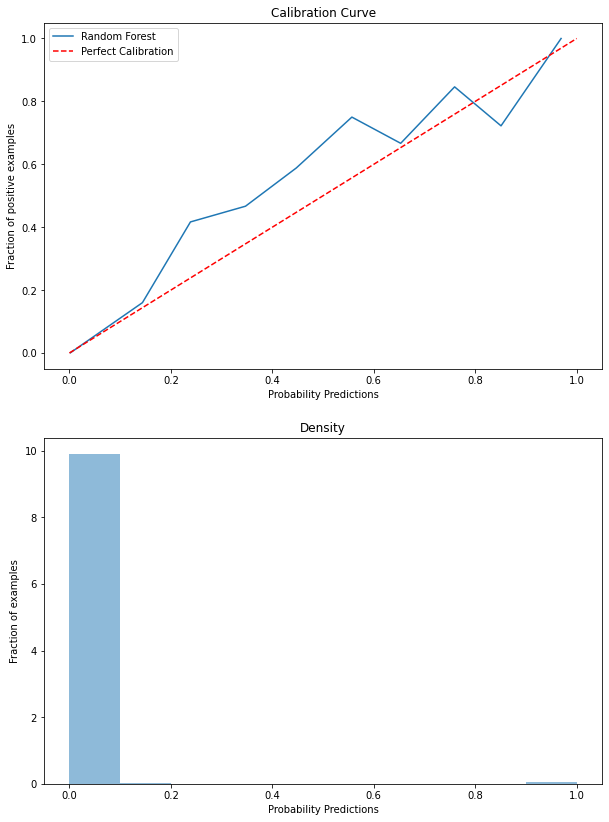

In [90]:
plot_calibration_curve(y_test,preds_sigmoid,bins=10)

For this particular dataset, the Isotonic Calibration worked better than Plat Scaling

In [79]:
# checking the roc score for this classifiers

print('ROC score for test data ISOTONIC: {}'.format(roc_auc_score(y_test,preds_iso)))

ROC score for test data ISOTONIC: 0.9990711962568993


In [80]:
# checking the roc score for this classifiers

print('ROC score for test data SIGMOID: {}'.format(roc_auc_score(y_test,preds_sigmoid)))

ROC score for test data SIGMOID: 0.9992028995761217


In [81]:
# the original score before calibrating
# get the ROC scores

preds_train = rf.predict_proba(X_train)[:,1]
print('ROC score for train data : {}'.format(roc_auc_score(y_train,preds_train)))

preds_test = rf.predict_proba(X_test)[:,1]
print('ROC score for test data : {}'.format(roc_auc_score(y_test,preds_test)))

ROC score for train data : 0.9969556399552467
ROC score for test data : 0.9818942663164445


- Seems the model performance also seems to be better with the calibrated classifier

In [82]:
# checking the brier scores - expecting to be much better

bs_test = brier_score_loss(y_test,preds_iso)
print('Brier score for test data ISOTONIC: {}'.format(bs_test))

Brier score for test data ISOTONIC: 0.0016450249010912866


In [83]:
bs_test = brier_score_loss(y_test,preds_sigmoid)
print('Brier score for test data SIGMOID: {}'.format(bs_test))

Brier score for test data SIGMOID: 0.0016577902195076002


In [84]:
# BEFORE calibration scores
bs_train = brier_score_loss(y_train,preds_train)
print('Brier score for train data : {}'.format(bs_train))

bs_test = brier_score_loss(y_test,preds_test)
print('Brier score for test data : {}'.format(bs_test))

Brier score for train data : 0.01770329692291271
Brier score for test data : 0.017903684052750977


- As expected, the brier scores for both the methods are pretty much better and improved.

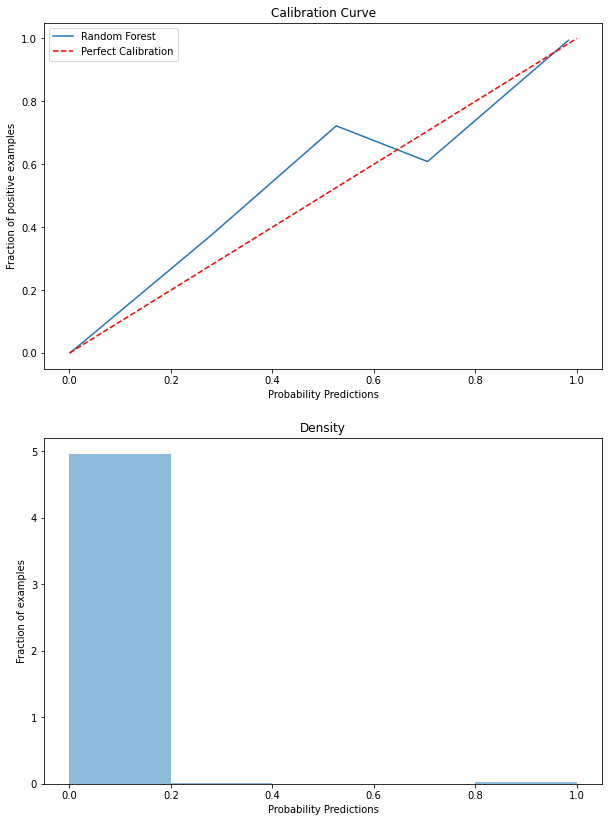

In [91]:
plot_calibration_curve(y_test,preds_iso,bins=5)

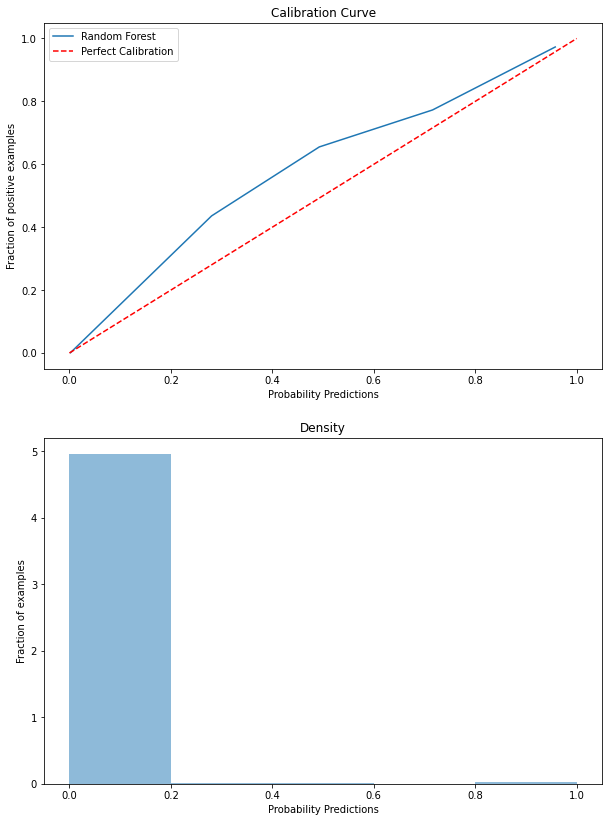

In [92]:
plot_calibration_curve(y_test,preds_sigmoid,bins=5)